In [1]:
import os

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256,expandable_segments:True"

In [3]:
import torch

In [4]:
import os, requests, json
from PIL import Image
from tqdm import tqdm
import pandas as pd

import openai
openai.api_key = 'insert key here'


from transformers import CLIPModel, CLIPProcessor, AutoTokenizer, AutoModel
'''
from diffusers import StableDiffusionPipeline, DDIMScheduler

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
for module in pipe.text_encoder.modules():
    if hasattr(module, "inplace") and module.inplace:
        module.inplace = False

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass
'''


'\nfrom diffusers import StableDiffusionPipeline, DDIMScheduler\n\npipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")\nfor module in pipe.text_encoder.modules():\n    if hasattr(module, "inplace") and module.inplace:\n        module.inplace = False\n\npipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)\npipe.enable_attention_slicing()\ntry:\n    pipe.enable_xformers_memory_efficient_attention()\nexcept Exception:\n    pass\n'

In [5]:
import re

def ensure_direct_image_url(url):
    """Convert Imgur/Dropbox URLs to direct image links if needed."""
    if "imgur.com" in url and not re.search(r'\.(jpg|jpeg|png|bmp)$', url):
        m = re.search(r'imgur\.com/(?:gallery/|a/)?([^.?&]+)', url)
        if m: return f"https://i.imgur.com/{m.group(1)}.jpg"
    return url

def smart_download_image(url, save_path):
    """Download an image with user-agent header, handling Dropbox links."""
    if "dropbox.com" in url:
        url = url.replace("?dl=0", "")
        if "?raw=1" not in url:
            url += "&raw=1" if "?" not in url else "&raw=1"
    headers = {"User-Agent": "Mozilla/5.0", "Accept-Encoding": "identity"}
    try:
        resp = requests.get(url, headers=headers, timeout=30)
        if resp.status_code == 200 and resp.headers.get('content-type','').startswith("image"):
            with open(save_path, "wb") as f: f.write(resp.content)
            return True
    except Exception as e:
        print(f"Download error for {url}: {e}")
    return False

df = pd.read_csv("RealEdit_train_split_urls.csv")
os.makedirs("originals", exist_ok=True)

N = 10
image_info = []
for i, row in tqdm(df.iterrows(), total=min(len(df), N)):
    if i >= N: break
    fname = row["input_image_name"]
    url = ensure_direct_image_url(str(row["input_url"]))
    save_path = f"originals/{fname}"
    if smart_download_image(url, save_path):
        image_info.append((fname, url, row.get("subreddit",""), str(row.get("title","")), str(row.get("selftext",""))))
    else:
        print(f"Skipping {fname}: download failed.")


 10%|█         | 1/10 [00:00<00:07,  1.18it/s]

Skipping 3v1cvp.jpg: download failed.


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


In [6]:
from transformers import CLIPTokenizer

In [7]:
import openai
from openai import OpenAI
import base64

In [8]:
import re

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

def truncate_caption_safely(caption, max_tokens=77):
    sentences = re.split(r'(?<=[.!?]) +', caption.strip())

    current_text = ""
    for sentence in sentences:
        proposed_text = (current_text + " " + sentence).strip()
        token_ids = tokenizer(proposed_text, return_tensors="pt", truncation=False)["input_ids"][0]
        if len(token_ids) > max_tokens:
            break
        current_text = proposed_text

    return current_text


captions = []
client = OpenAI(api_key=openai.api_key)

image_dir = "originals"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))][:N]
captions = []

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    if not os.path.exists(image_path) or os.path.getsize(image_path) < 1024:
        print(f"Skipping {image_file}: file missing or too small.")
        continue

    try:
        with open(image_path, "rb") as img_file:
            image_bytes = img_file.read()
            base64_img = base64.b64encode(image_bytes).decode("utf-8")

        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Describe the image in full detail, but limit your response to under 50 words. Focus on what's visually clear. Avoid exaggeration or hallucination. Do not include information that is not clearly visible in the image."},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_img}"}}
                    ]
                }
            ],
            max_tokens=77
        )

        caption = response.choices[0].message.content.strip()
        caption = truncate_caption_safely(caption)
        captions.append((image_file, caption))

    except Exception as e:
        print(f"{image_file}, Error: {str(e)}")


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Skipping 3vn0dc.jpeg: file missing or too small.


In [9]:
from tabulate import tabulate
df = pd.DataFrame(captions, columns=["Image", "Caption"])
print(tabulate(df, headers="keys", tablefmt="github", showindex=True))

|    | Image       | Caption                                                                                                                                                                                                                                                                                          |
|----|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | 3vtbmy.jpg  | A couple stands on a beach by the ocean's edge. The woman wears a light shirt and shorts, and the man is shirtless. They stand close, embracing, with the sea stretching out behind them under a dusky sky.                                                                                      |
|  1 | 3vo9iy.jpg  | A black and white photo of a group of eleve

In [11]:
import tiktoken

In [12]:
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [15]:
all_edits = {}
cap_and_edits = {}
for (fname, cap) in captions:
    print(f"\nGenerating edits for '{fname}' with caption: {cap}")
    prompt = (
    "You are simulating real user editing behavior for a dataset of image edits.\n"
    "Given a description of an image, imagine how actual users would ask to modify it. "
    "These edits should be creative, realistic, and specific — things a person might type into an AI editor, like:\n"
    "- 'Add a dog sitting near the woman'\n"
    "- 'Make the sunset more vibrant'\n"
    "- 'Change the man’s outfit to a business suit'\n"
    "- 'Remove the second person from the left'\n"
    "- 'Make the child look older'\n"
    "Each edit should involve a meaningful visual change to the image, not just generic filters like 'increase contrast'.\n"
    "\n"
    "For each instruction, generate a matching edited image caption that describes the image *after* the edit.\n"
    "Each 'edited_caption' must be **under 77 tokens**, even after tokenization (not just word count).\n"
    "Avoid repetitions. The 10 edits must be diverse (e.g. subject, background, object-level, style).\n"
    "\n"
    "Output a JSON array of 10 items, where each item is an object with two fields:\n"
    "- 'instruction': the user's edit request\n"
    "- 'edited_caption': the caption for the image after applying that edit\n"
    "Do not include any explanation. Return only the JSON array.\n\n"
    f"Image Description: \"{cap}\""
    )
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.8
        )
        gpt_output = response.choices[0].message.content
        start = gpt_output.find('[')
        end = gpt_output.rfind(']') + 1
        edits = json.loads(gpt_output[start:end])
    except Exception as e:
        print(f"GPT API call failed for {fname}: {e}")
        continue

    if not isinstance(edits, list) or len(edits) != 10:
        print(f"Unexpected format for {fname}, skipping.")
        continue

    filtered_edits = []
    for item in edits:
        tok_len = len(enc.encode(item["edited_caption"]))
        if tok_len < 77:
            filtered_edits.append(item)
        else:
            print(f"Skipping overlong caption (len={tok_len}) for '{fname}': {item['edited_caption']}")

    if len(filtered_edits) < 10:
        print(f"Only {len(filtered_edits)} valid edits (under 77 tokens) for {fname}.")

    all_edits[fname] = filtered_edits

    cap_and_edits[fname] = []
    cap_and_edits[fname].append(cap)
    cap_and_edits[fname].append([])

    for idx, item in enumerate(filtered_edits, 1):
        print(f" {idx}. INSTR: {item['instruction']} | CAPTION: {item['edited_caption']}")
        cap_and_edits[fname][1].append(item['edited_caption'])
    

 1. INSTR: Add a flock of seagulls flying overhead | CAPTION: A couple stands on a beach by the ocean's edge. The woman wears a light shirt and shorts, and the man is shirtless. They stand close, embracing, with the sea stretching out behind them under a dusky sky, as seagulls fly above.
 2. INSTR: Change the dusky sky to a vibrant sunset | CAPTION: A couple stands on a beach by the ocean's edge. The woman wears a light shirt and shorts, and the man is shirtless. They stand close, embracing, with the sea stretching out behind them under a vibrant sunset.
 3. INSTR: Add a sandcastle in the background | CAPTION: A couple stands on a beach by the ocean's edge. The woman wears a light shirt and shorts, and the man is shirtless. They stand close, embracing, with a sandcastle in the background and the sea stretching out behind them under a dusky sky.
 4. INSTR: Change the woman's attire to a sundress | CAPTION: A couple stands on a beach by the ocean's edge. The woman wears a sundress and th

In [17]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline
#from diffusers import StableDiffusion3Pipeline
#from diffusers import DiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import seq_aligner

In [18]:
MY_TOKEN = '<replace with your token>'
LOW_RESOURCE = False
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=MY_TOKEN).to(device)
#ldm_stable = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large")
#ldm_stable = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large", torch_dtype=torch.bfloat16)
#ldm_stable = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large-turbo", torch_dtype=torch.bfloat16)
#ldm_stable = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large-turbo")
#ldm_stable = ldm_stable.to(device)
tokenizer = ldm_stable.tokenizer

Keyword arguments {'use_auth_token': '<replace with your token>'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
class LocalBlend:

    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold


class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

        
class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)
        

class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer


In [20]:
from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [21]:
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    ptp_utils.view_images(images)
    return images, x_t

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
prompts = ["A painting of a squirrel eating a burger"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
show_cross_attention(controller, res=16, from_where=("up", "down"))

In [ ]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger"]

controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=0.4)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=True)


OG Caption: A couple stands on a beach by the ocean's edge. The woman wears a light shirt and shorts, and the man is shirtless. They stand close, embracing, with the sea stretching out behind them under a dusky sky.


  0%|          | 0/51 [00:00<?, ?it/s]

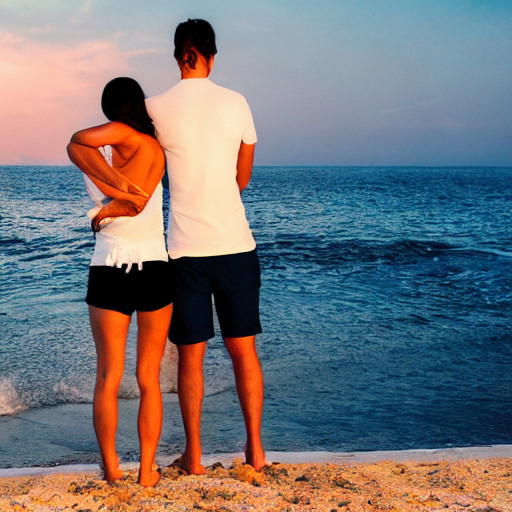

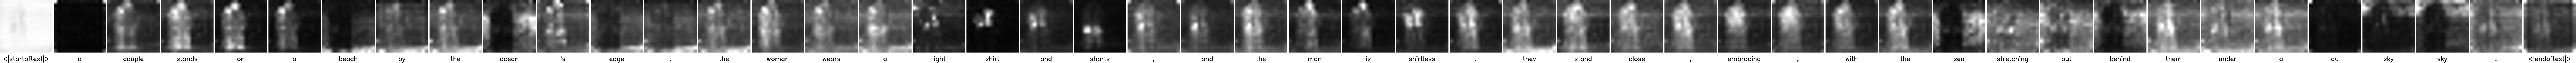

EDITED Caption:A couple stands on a beach by the ocean's edge. The woman wears a light shirt and shorts, and the man is shirtless. They stand close, embracing, with the sea stretching out behind them under a dusky sky, as seagulls fly above.


  0%|          | 0/51 [00:00<?, ?it/s]

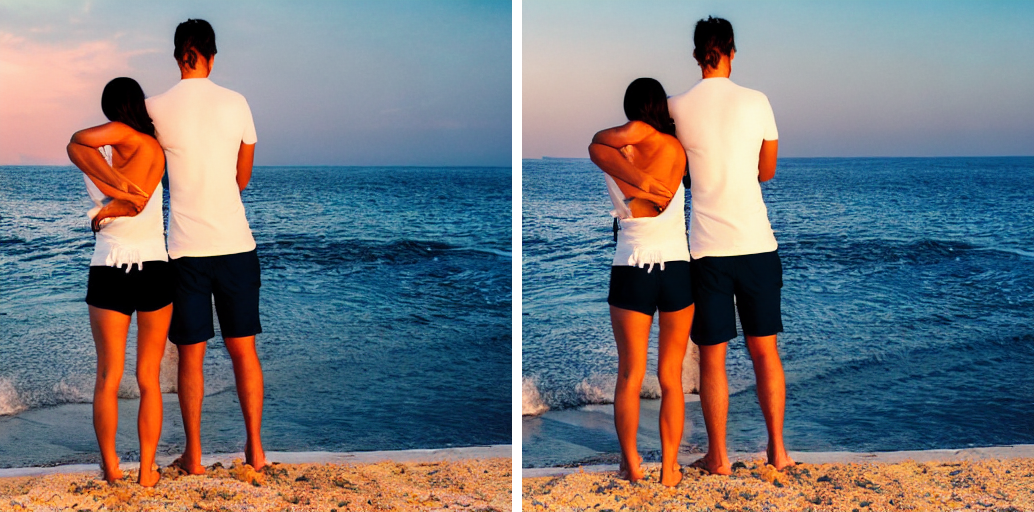

In [23]:
#print(cap_and_edits)
#print("OG Caption: " + str(cap_and_edits))
for _, captions in cap_and_edits.items():
    og_cap = captions[0]
    edited_caps = captions[1]

    print("OG Caption: " + og_cap)

    g_cpu = torch.Generator().manual_seed(8888)
    prompts = [og_cap]
    controller = AttentionStore()
    image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
    show_cross_attention(controller, res=16, from_where=("up", "down"))

    for c in edited_caps:
        print("EDITED Caption:" + str(c))
        #os.makedirs("first_img_edits", exist_ok=True)
        #img = Image.fromarray(image[0])  # image[0] = (H, W, C), dtype=uint8
        prompts = [og_cap, c]

        #controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=0.4)
        #_ = run_and_display(prompts, controller, latent=x_t, run_baseline=True)


        controller = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.5, self_replace_steps=.2)
        _ = run_and_display(prompts, controller, latent=x_t)

        break

        # Define path to save
        #save_path = "output_dir/generated_image.png"

        # Ensure directory exists
        #os.makedirs(os.path.dirname(save_path), exist_ok=True)

        #img.save(save_path)




    break